# Problem statement:
We want to build a surrogate model with a Convolutional Recurrent NN architecture to learn and predict the time-evolution of a bi-dimensional phase-field.
It will be supplied as an image (npy array) with $n \times n$ pixels. The convolutional architecture helps us capturing the local correlations between nearby correlated pixels, while the recurrent architecture helps us better learn the temporal evolution.

## Step 4

We aim to address the same study problem as in Step 3, but using a different strategy.
Instead of providing two inputs and predicting two outputs, we now provide two inputs and predict only one output. The model is then applied iteratively to each pixel: the first input corresponds to the pixel value we want to predict at the next time step, while the second input corresponds to the value of another pixel.

This approach is valid because the system’s time evolution is invariant under pixel exchange — each pixel behaves identically. As a result, the model is inherently invariant under this transformation (unlike the previous model that predicted two outputs simultaneously). Moreover, this formulation scales more efficiently as the number of pixels $N$ increases, since it reduces the model’s output dimensionality from $N$ to 1, significantly lowering its complexity.

As a reminder of the study-problem we are investigating:

We consider a system with two interacting pixels. 
Given pixel concentrations $A_t, B_t$, and $\Delta_t = A_t - B_t$, the time-evolution is governed by a mixing law:
$$
A_{t+1} = A_t - \Delta_t \, B_t \, \alpha \, dt \\
B_{t+1} = B_t + \Delta_t \, A_t \, \alpha \, dt
$$


We import some useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We use the same parameters and function to compute the time-evolution

In [2]:
alpha = 0.05 # scaling factor
dt = 1 # integration time-step
T = 100 # number of time steps
x0 = np.array([1, 0]) # initial condition
t = np.arange(T+1) # time
x = np.zeros((2, T+1)) # scalar to evolve

In [3]:
# function defining the time-evolution
def propagate(x, alpha, dt):
    #x_i = x*(1 - np.cos((x-1)*np.pi)*alpha*dt) + 0.005*dt
    x_i = np.zeros(2)
    x_i[0] = x[0] - (x[0]-x[1])*x[1]*alpha*dt
    x_i[1] = x[1] - (x[1]-x[0])*x[0]*alpha*dt
    
    return x_i

Let's check a bunch of starting conditions

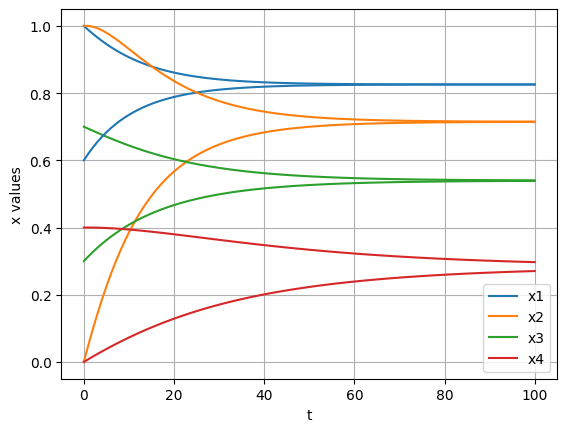

In [4]:
# checking the behaviour formultiple starting conditions
x1 = np.zeros((2, T+1))
x2 = np.zeros((2, T+1))
x3 = np.zeros((2, T+1))
x4 = np.zeros((2, T+1))
x1[:, 0] = [1.0, 0.6]
x2[:, 0] = [0.0, 1.0]
x3[:, 0] = [0.7, 0.3]
x4[:, 0] = [0.0, 0.4]

for i in range(1, T+1):
    x1[:, i] = propagate(x1[:, i-1], alpha, dt)
    x2[:, i] = propagate(x2[:, i-1], alpha, dt)
    x3[:, i] = propagate(x3[:, i-1], alpha, dt)
    x4[:, i] = propagate(x4[:, i-1], alpha, dt)

plt.plot(t, x1[0, :], label='x1')
plt.plot(t, x2[0, :], label='x2')
plt.plot(t, x3[0, :], label='x3')
plt.plot(t, x4[0, :], label='x4')
plt.plot(t, x1[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.plot(t, x2[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(t, x3[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
plt.plot(t, x4[1, :], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
plt.xlabel('t')
plt.ylabel('x values')
plt.legend()
plt.grid()
#plt.yscale('log')

We can re-write the `propagate` function to explicitly show the pixel we are updating, depending on the other adjacent pixel.

In [5]:
# function defining the time-evolution
def prop_one_out(a, b, alpha, dt):
    a_next = a - (a-b)*b*alpha*dt
    
    return a_next

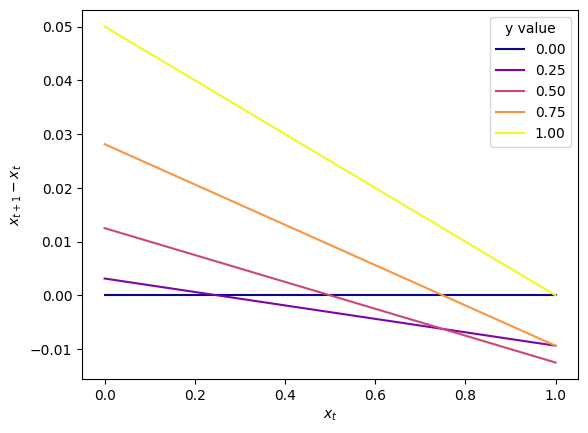

In [6]:
a = np.linspace(0, 1, 200)
b = np.linspace(0, 1, 5)

a_next = np.zeros(a.shape)

cmap = plt.cm.plasma  # 'viridis' or you can also try 'plasma', 'inferno', 'cividis', etc.
# Normalize the color values to span the range of your indices
norm = plt.Normalize(vmin=0, vmax=len(b) - 1)

for j in range(len(b)):
    for i in range(200):
        a_next[i] = prop_one_out(a[i], b[j], alpha, dt)

    delta = a_next - a

    color = cmap(norm(j))
    plt.plot(a, delta, '-', color=color, label=f"{b[j]:.2f}")


plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1} - x_t$')
plt.legend(title='y value')

Alternatively we can represent it like this:

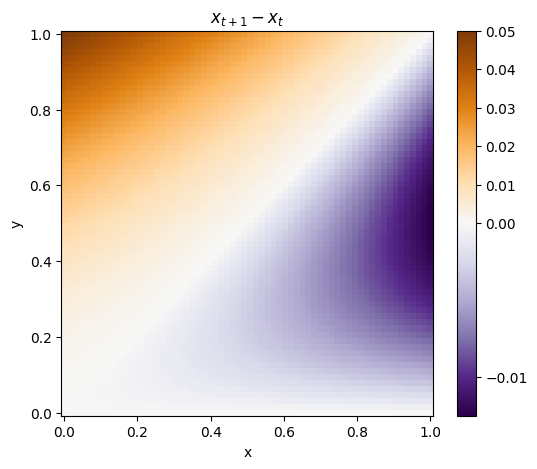

In [7]:
# Define grid
x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x, y)

x_next = np.zeros(X.shape)

# Define your function f(x, y)
#for j in range(64):
#    for i in range(64):
#        x_next[i, j] = prop_one_out(X[i, j], Y[i, j], alpha, dt)

# we actually can avoid using the loop
x_next = prop_one_out(X, Y, alpha, dt)

Z = x_next - X

# Plot using imshow or pcolormesh
plt.figure(figsize=(6, 5))

from matplotlib.colors import TwoSlopeNorm
# Create normalization centered at 0
norm = TwoSlopeNorm(vmin=Z.min(), vcenter=0.0, vmax=Z.max())

plt.pcolormesh(X, Y, Z, shading='auto', cmap='PuOr_r', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$x_{t+1} - x_{t}$')
plt.show()

Ok, let's try to learn such dynamics (= learn this two-variable function).

First of all we create a dataset of conditions, and we want to predict the next step.

Let's import the libraries to build such NN model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [9]:
def generate_dataset(N, alpha=alpha, dt=dt):
    xy = np.random.rand(N, 2) # starting point
    x_next = prop_one_out(xy[:, 0], xy[:, 1], alpha, dt)   

    z = x_next-xy[:, 0]

    np.save('xy.npy', xy)
    np.save('x_next.npy', x_next)
    np.save('z.npy', z)

    # =========================
    # 1. Load dataset
    # =========================
    X = np.load("xy.npy")  
    y = np.load("z.npy")    

    #X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit scaler on y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    # Wrap into dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # =========================
    # 2. Train-validation split
    # =========================
    val_ratio = 0.2
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    return train_dataset, val_dataset, train_loader, val_loader, y_scaler

    

In [10]:
def new_model(in_dim, out_dim, act_fun, my_nn, lr, epochs, train_loader, val_loader):
    class Net(nn.Module):
        def __init__(self, in_dim, out_dim):  
            super(Net, self).__init__()
            if len(my_nn) == 1:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], out_dim),
                    )

            if len(my_nn) == 2:
                if act_fun == 'ReLU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ReLU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ReLU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
            
                if act_fun == 'ELU':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.ELU(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.ELU(),
                        nn.Linear(my_nn[-1], out_dim),
                    )

                if act_fun == 'Tanh':
                    self.layers = nn.Sequential(
                        nn.Linear(in_dim, my_nn[0]),
                        nn.Tanh(),
                        nn.Linear(my_nn[0], my_nn[-1]),
                        nn.Tanh(),
                        nn.Linear(my_nn[-1], out_dim),
                    )
        
        def forward(self, x):
            return self.layers(x)

    model = Net(in_dim, out_dim)

    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_tra_saved = np.empty(epochs)
    loss_val_saved = np.empty(epochs)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view_as(preds))  # reshape if needed
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb.view_as(preds))
                val_loss += loss.item()
    
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")
    
        loss_tra_saved[epoch] = train_loss / len(train_loader)
        loss_val_saved[epoch] = val_loss / len(val_loader)

    torch.save(model.state_dict(), "model.pth")

    saved_model = Net(in_dim, out_dim)
    saved_model.load_state_dict(torch.load("model.pth"))
    saved_model.eval()

    return loss_tra_saved, loss_val_saved, saved_model

In [11]:
def plot_loss(epochs, loss_tra_saved, loss_val_saved):
    plt.plot(range(epochs), loss_tra_saved, label='training')
    plt.plot(range(epochs), loss_val_saved, label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

In [12]:
def subset_to_numpy(subset):
    X = torch.stack([subset[i][0] for i in range(len(subset))])
    y = torch.stack([subset[i][1] for i in range(len(subset))])
    
    return X.numpy(), y.numpy()

In [13]:
def next_step_pred(train_dataset, val_dataset, saved_model):
    a = np.linspace(0, 1, 200)
    b = np.linspace(0, 1, 5)

    a_next = np.zeros(a.shape)
    delta_pred = np.zeros(a.shape)

    cmap = plt.cm.plasma  # 'viridis' or you can also try 'plasma', 'inferno', 'cividis', etc.
    # Normalize the color values to span the range of your indices
    norm = plt.Normalize(vmin=0, vmax=len(b) - 1)

    with torch.no_grad():
        for j in range(len(b)):
            for i in range(len(a)):
                a_next[i] = prop_one_out(a[i], b[j], alpha, dt)
                delta_pred[i] = saved_model(torch.tensor(np.array([a[i], b[j]]), dtype=torch.float32))
                delta_pred[i] = y_scaler.inverse_transform(delta_pred[i].reshape(-1, 1)).item()

            delta = a_next - a

            color = cmap(norm(j))
            plt.plot(a, delta, '--', linewidth=3, color=color, label=f"{b[j]:.2f}")
            plt.plot(a, delta_pred, '-', color=color)

    plt.xlabel(r'$x_t$')
    plt.ylabel(r'$x_{t+1} - x_t$')
    plt.legend(title='y value')


In [20]:
def predict_dynamics(alpha, dt, y_scaler, saved_model, T):
    t = np.arange(T+1)
    x1_true = np.zeros((T+1, 2))
    x2_true = np.zeros((T+1, 2))
    x3_true = np.zeros((T+1, 2))
    x4_true = np.zeros((T+1, 2))

    x1_true[0, :] = [1.0, 0.6]
    x2_true[0, :] = [0.0, 1.0]
    x3_true[0, :] = [0.7, 0.3]
    x4_true[0, :] = [0.0, 0.4]

    x1_pred = np.zeros((T+1, 2))
    x2_pred = np.zeros((T+1, 2))
    x3_pred = np.zeros((T+1, 2))
    x4_pred = np.zeros((T+1, 2))

    x1_pred[0, :] = [1.0, 0.6]
    x2_pred[0, :] = [0.0, 1.0]
    x3_pred[0, :] = [0.7, 0.3]
    x4_pred[0, :] = [0.0, 0.4]

    for i in range(1, T+1):
        x1_true[i, 0] = prop_one_out(x1_true[i-1, 0], x1_true[i-1, 1], alpha, dt)
        x2_true[i, 0] = prop_one_out(x2_true[i-1, 0], x2_true[i-1, 1], alpha, dt)
        x3_true[i, 0] = prop_one_out(x3_true[i-1, 0], x3_true[i-1, 1], alpha, dt)
        x4_true[i, 0] = prop_one_out(x4_true[i-1, 0], x4_true[i-1, 1], alpha, dt)
        x1_true[i, 1] = prop_one_out(x1_true[i-1, 1], x1_true[i-1, 0], alpha, dt)
        x2_true[i, 1] = prop_one_out(x2_true[i-1, 1], x2_true[i-1, 0], alpha, dt)
        x3_true[i, 1] = prop_one_out(x3_true[i-1, 1], x3_true[i-1, 0], alpha, dt)
        x4_true[i, 1] = prop_one_out(x4_true[i-1, 1], x4_true[i-1, 0], alpha, dt)

    with torch.no_grad():
        for i in range(1, T+1):        
            # add "unsqueeze(0)" because it transforms from (2,) to (1, 2) cosistent with the model's input
            x1_pred[i, 0] = x1_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x1_pred[i-1, 0], x1_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x2_pred[i, 0] = x2_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x2_pred[i-1, 0], x2_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x3_pred[i, 0] = x3_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x3_pred[i-1, 0], x3_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x4_pred[i, 0] = x4_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x4_pred[i-1, 0], x4_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x1_pred[i, 1] = x1_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x1_pred[i-1, 1], x1_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x2_pred[i, 1] = x2_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x2_pred[i-1, 1], x2_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x3_pred[i, 1] = x3_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x3_pred[i-1, 1], x3_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x4_pred[i, 1] = x4_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x4_pred[i-1, 1], x4_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()

    first_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    second_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    third_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
    fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

    plt.figure(figsize=(10,8))

    plt.plot(t, x1_true[:, 0], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 0], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 0], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 0], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 0], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 0], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 0], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 0], '-', label="x4_pred", color=fourth_color)

    plt.plot(t, x1_true[:, 1], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 1], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 1], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 1], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 1], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 1], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 1], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 1], '-', label="x4_pred", color=fourth_color)

    plt.xlabel('t')
    plt.ylabel('x values')
    #plt.legend()
    plt.grid()

What works:
- dataset size: 500
- train val split: 0.20
- layers/neurons: [3]
- activation functions: Tanh
- learning rate: 0.001
- epochs: 3000

In [84]:
N = 1000
in_dim = 2
out_dim = 1
act_fun = 'Tanh'
my_nn = [8, 4]
lr = 0.002
epochs = 1000

In [ ]:
train_dataset, val_dataset, train_loader, val_loader, y_scaler = generate_dataset(N=N, alpha=alpha, dt=dt)
loss_tra_saved, loss_val_saved, saved_model = new_model(in_dim=in_dim, out_dim=out_dim, 
                                                        act_fun=act_fun, my_nn=my_nn, lr=lr, epochs=epochs, 
                                                        train_loader=train_loader, val_loader=val_loader)

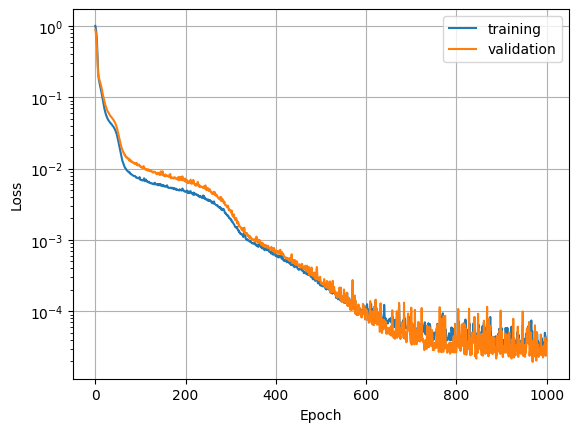

In [86]:
plot_loss(epochs, loss_tra_saved, loss_val_saved)

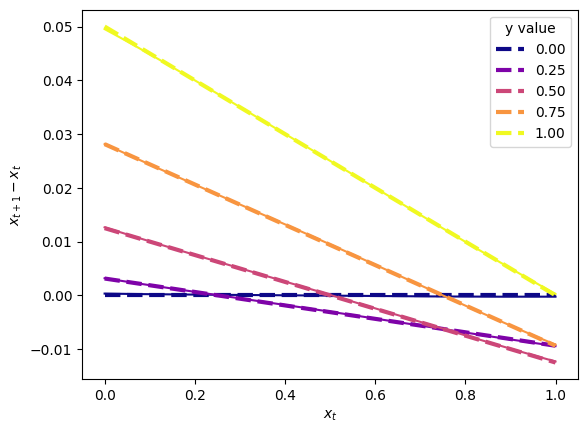

In [87]:
next_step_pred(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model)

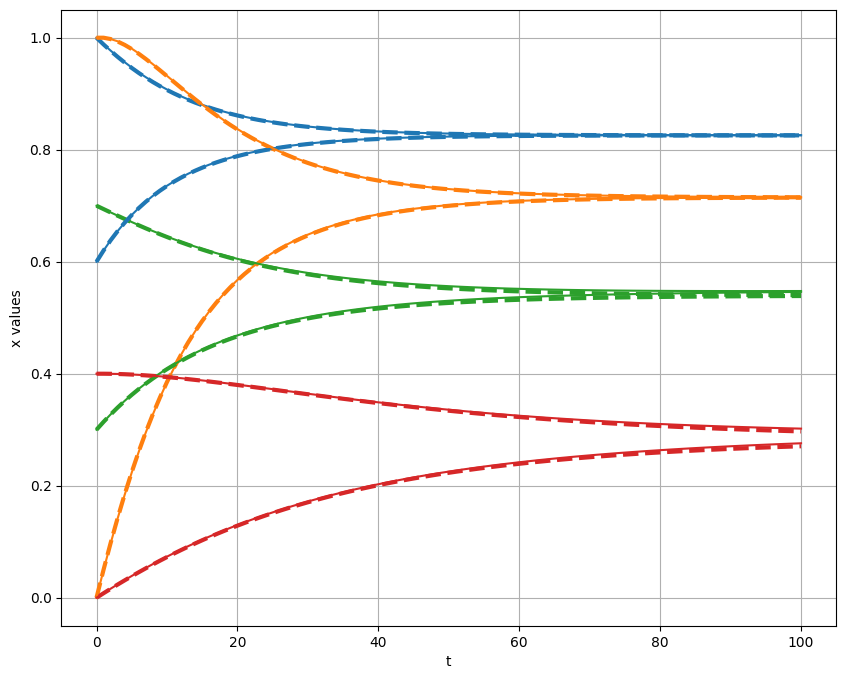

In [88]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model, T=100)

Let's check the long time behaviour

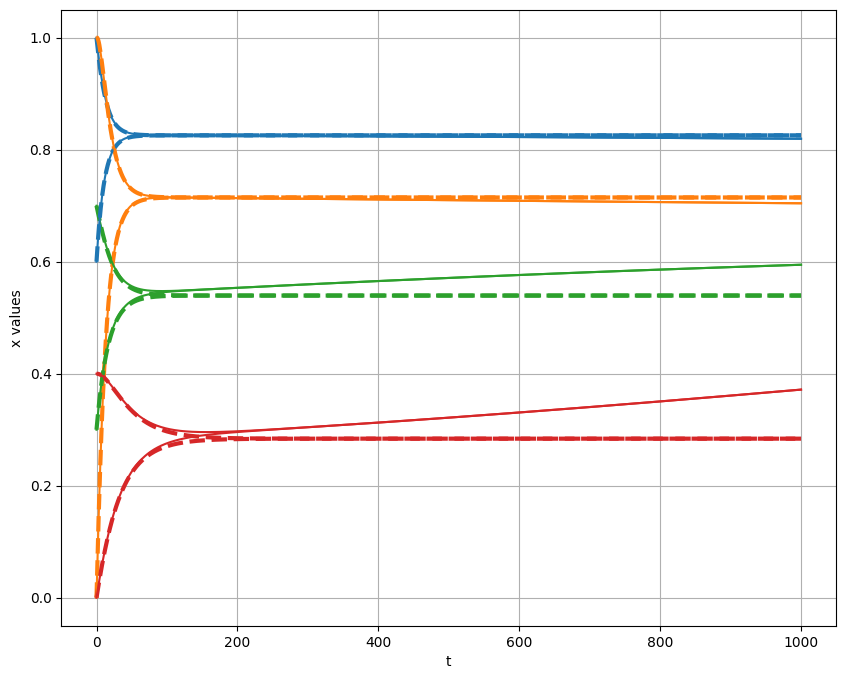

In [89]:
predict_dynamics(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model, T=1000)

In [90]:
def next_step_diagonal(train_dataset, val_dataset, saved_model):
    a = np.linspace(0, 1, 200)

    a_next = np.zeros(a.shape)
    delta_pred = np.zeros(a.shape)

    with torch.no_grad():
        for i in range(len(a)):
            a_next[i] = prop_one_out(a[i], a[i], alpha, dt)
            delta_pred[i] = saved_model(torch.tensor(np.array([a[i], a[i]]), dtype=torch.float32))
            delta_pred[i] = y_scaler.inverse_transform(delta_pred[i].reshape(-1, 1)).item()

    delta = a_next - a

    plt.plot(a, delta, '--', linewidth=3)
    plt.plot(a, delta_pred, '-')

    plt.xlabel(r'$x_t$')
    plt.ylabel(r'$x_{t+1} - x_t$')


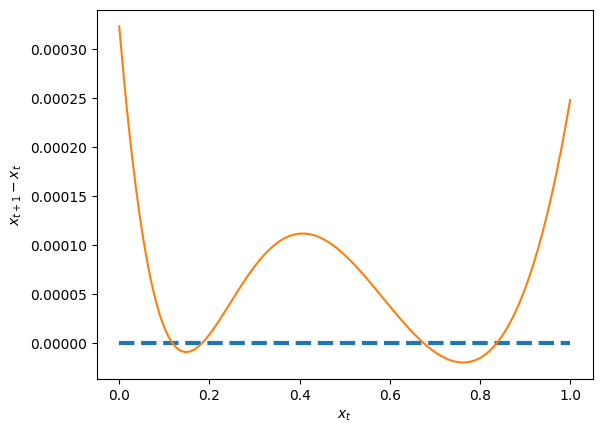

In [91]:
next_step_diagonal(train_dataset=train_dataset, val_dataset=val_dataset, saved_model=saved_model)

Ah! That's why it drifts...

We can try to do feature engineering supplying not only $(x, y)$ but maybe also $(x-y)$ or $(x-y)^2$.
But still it won't be much better. We have to use an exact way to impose $\tilde{f}(x,y) = 0$ for $x=y$.

Two methods:

- Projection layer:  The NN was tasked to learn $f(x,y)$ and learnt a pretty close $\tilde{f}(x,y)$. We then build a final projection layer so that the output is actually 
$$
\tilde{f}(x,y) - e^{-\frac{1}{2} (\frac{x-y}{\sigma})^2} \tilde{f}(x,x)
$$
Notice that by construction, this expression is 0 for $x=y$ and becomes $\sim \tilde{f}(x,y)$ for $(x-y) > 2\sigma$ 

- Axiliary function: The other method is to train another model, this time not on predicting $f(x,y)$ itself but an auxiliary function $g(x,y)$ such that
$$
f(x,y) = (x-y) \, g(x,y)
$$

### Projection layer method

In [92]:
def predict_dynamics_proj(alpha, dt, y_scaler, saved_model, T):
    t = np.arange(T+1)
    x1_true = np.zeros((T+1, 2))
    x2_true = np.zeros((T+1, 2))
    x3_true = np.zeros((T+1, 2))
    x4_true = np.zeros((T+1, 2))

    x1_true[0, :] = [1.0, 0.6]
    x2_true[0, :] = [0.0, 1.0]
    x3_true[0, :] = [0.7, 0.3]
    x4_true[0, :] = [0.0, 0.4]

    x1_pred = np.zeros((T+1, 2))
    x2_pred = np.zeros((T+1, 2))
    x3_pred = np.zeros((T+1, 2))
    x4_pred = np.zeros((T+1, 2))

    x1_pred[0, :] = [1.0, 0.6]
    x2_pred[0, :] = [0.0, 1.0]
    x3_pred[0, :] = [0.7, 0.3]
    x4_pred[0, :] = [0.0, 0.4]

    for i in range(1, T+1):
        x1_true[i, 0] = prop_one_out(x1_true[i-1, 0], x1_true[i-1, 1], alpha, dt)
        x2_true[i, 0] = prop_one_out(x2_true[i-1, 0], x2_true[i-1, 1], alpha, dt)
        x3_true[i, 0] = prop_one_out(x3_true[i-1, 0], x3_true[i-1, 1], alpha, dt)
        x4_true[i, 0] = prop_one_out(x4_true[i-1, 0], x4_true[i-1, 1], alpha, dt)
        x1_true[i, 1] = prop_one_out(x1_true[i-1, 1], x1_true[i-1, 0], alpha, dt)
        x2_true[i, 1] = prop_one_out(x2_true[i-1, 1], x2_true[i-1, 0], alpha, dt)
        x3_true[i, 1] = prop_one_out(x3_true[i-1, 1], x3_true[i-1, 0], alpha, dt)
        x4_true[i, 1] = prop_one_out(x4_true[i-1, 1], x4_true[i-1, 0], alpha, dt)

    with torch.no_grad():
        for i in range(1, T+1):        
            # add "unsqueeze(0)" because it transforms from (2,) to (1, 2) cosistent with the model's input
            x1_pred[i, 0] = x1_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x1_pred[i-1, 0], x1_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x1_pred[i, 0] -= np.exp(-0.5*((x1_pred[i-1, 0]-x1_pred[i-1, 1])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x1_pred[i-1, 0], x1_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x2_pred[i, 0] = x2_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x2_pred[i-1, 0], x2_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x2_pred[i, 0] -= np.exp(-0.5*((x2_pred[i-1, 0]-x2_pred[i-1, 1])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x2_pred[i-1, 0], x2_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x3_pred[i, 0] = x3_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x3_pred[i-1, 0], x3_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x3_pred[i, 0] -= np.exp(-0.5*((x3_pred[i-1, 0]-x3_pred[i-1, 1])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x3_pred[i-1, 0], x3_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x4_pred[i, 0] = x4_pred[i-1, 0] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x4_pred[i-1, 0], x4_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x4_pred[i, 0] -= np.exp(-0.5*((x4_pred[i-1, 0]-x4_pred[i-1, 1])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x4_pred[i-1, 0], x4_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            

            x1_pred[i, 1] = x1_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x1_pred[i-1, 1], x1_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x1_pred[i, 1] -= np.exp(-0.5*((x1_pred[i-1, 1]-x1_pred[i-1, 0])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x1_pred[i-1, 1], x1_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x2_pred[i, 1] = x2_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x2_pred[i-1, 1], x2_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x2_pred[i, 1] -= np.exp(-0.5*((x2_pred[i-1, 1]-x2_pred[i-1, 0])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x2_pred[i-1, 1], x2_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x3_pred[i, 1] = x3_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x3_pred[i-1, 1], x3_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x3_pred[i, 1] -= np.exp(-0.5*((x3_pred[i-1, 1]-x3_pred[i-1, 0])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x3_pred[i-1, 1], x3_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            
            x4_pred[i, 1] = x4_pred[i-1, 1] + y_scaler.inverse_transform(saved_model(torch.tensor(
                np.array([x4_pred[i-1, 1], x4_pred[i-1, 0]]), dtype=torch.float32)).reshape(-1, 1)).item()
            x4_pred[i, 1] -= np.exp(-0.5*((x4_pred[i-1, 1]-x4_pred[i-1, 0])/0.05)**2)*y_scaler.inverse_transform(saved_model(
                torch.tensor(np.array([x4_pred[i-1, 1], x4_pred[i-1, 1]]), dtype=torch.float32)).reshape(-1, 1)).item()
            

    first_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    second_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    third_color  = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
    fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

    plt.figure(figsize=(10,8))

    plt.plot(t, x1_true[:, 0], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 0], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 0], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 0], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 0], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 0], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 0], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 0], '-', label="x4_pred", color=fourth_color)

    plt.plot(t, x1_true[:, 1], '--', label='x1_true', linewidth=3, color=first_color)
    plt.plot(t, x2_true[:, 1], '--', label='x2_true', linewidth=3, color=second_color)
    plt.plot(t, x3_true[:, 1], '--', label='x3_true', linewidth=3, color=third_color)
    plt.plot(t, x4_true[:, 1], '--', label='x4_true', linewidth=3, color=fourth_color)

    plt.plot(t, x1_pred[:, 1], '-', label="x1_pred", color=first_color)
    plt.plot(t, x2_pred[:, 1], '-', label="x2_pred", color=second_color)
    plt.plot(t, x3_pred[:, 1], '-', label="x3_pred", color=third_color)
    plt.plot(t, x4_pred[:, 1], '-', label="x4_pred", color=fourth_color)

    plt.xlabel('t')
    plt.ylabel('x values')
    #plt.legend()
    plt.grid()

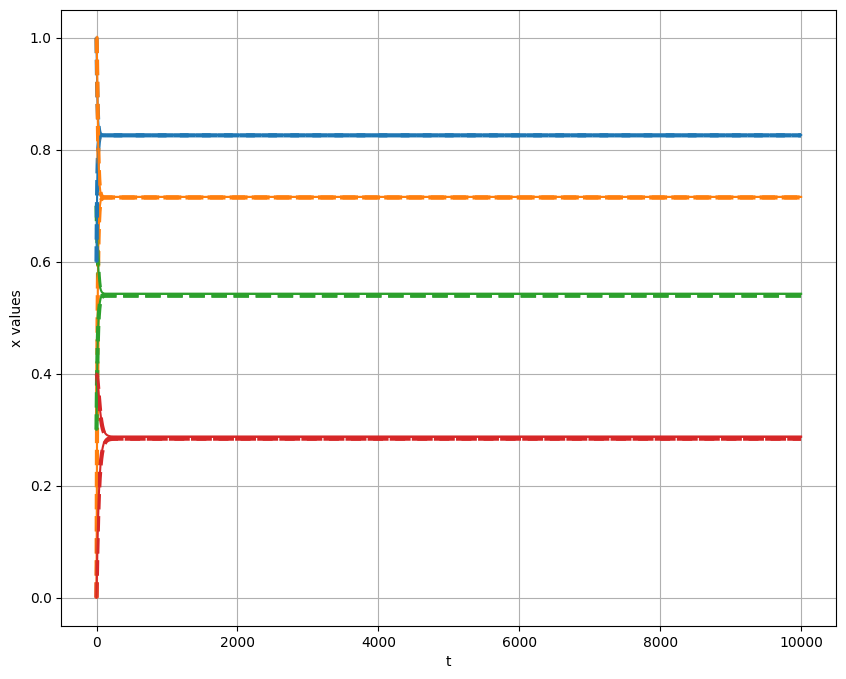

In [93]:
predict_dynamics_proj(alpha=alpha, dt=dt, y_scaler=y_scaler, saved_model=saved_model, T=10000)

### Auxiliary function method
We are not gonna implement it. Just two notes:
- We can't just numerically take $f(x,y)$ and divide it by $(x-y)$ due to $0/0$ issues
- We are basically telling the shape of the function to the NN. It's way easier and generally requires less parameters. 

$$f(x,y)$$

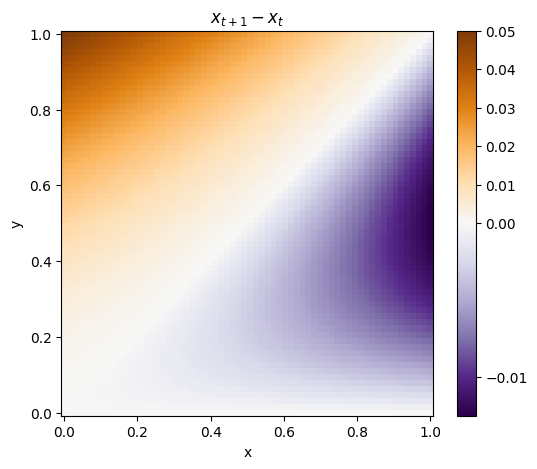

In [51]:
# Define grid
x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x, y)

x_next = np.zeros(X.shape)
x_next = prop_one_out(X, Y, alpha, dt)

Z = x_next - X

# Plot using imshow or pcolormesh
plt.figure(figsize=(6, 5))

from matplotlib.colors import TwoSlopeNorm
# Create normalization centered at 0
norm = TwoSlopeNorm(vmin=Z.min(), vcenter=0.0, vmax=Z.max())

plt.pcolormesh(X, Y, Z, shading='auto', cmap='PuOr_r', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$x_{t+1} - x_{t}$')
plt.show()

$$g(x,y) = f(x,y)/(x-y)$$

C:\Users\andre\AppData\Local\Temp\ipykernel_12712\1088376444.py:9: RuntimeWarning: divide by zero encountered in divide
  Z = (x_next - X + 1e-10) / (X-Y + (X-Y)*1e-10)


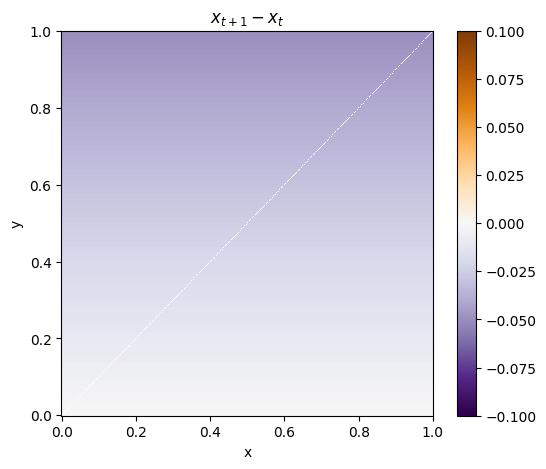

In [ ]:
# Define grid
x = np.linspace(0, 1, 512)
y = np.linspace(0, 1, 512)
X, Y = np.meshgrid(x, y)

x_next = np.zeros(X.shape)
x_next = prop_one_out(X, Y, alpha, dt)

Z = (x_next - X + 1e-10) / (X-Y + 1e-10)

# Plot using imshow or pcolormesh
plt.figure(figsize=(6, 5))

from matplotlib.colors import TwoSlopeNorm
# Create normalization centered at 0
norm = TwoSlopeNorm(vmin=Z.min(), vcenter=0.0, vmax=Z.max())

plt.pcolormesh(X, Y, Z, shading='auto', cmap='PuOr_r', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$x_{t+1} - x_{t}$')
plt.show()